In [34]:
### STEP 1: Imports & Setup
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

### STEP 2: Custom Dataset
class LensDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.samples = []
        self.class_names = sorted([d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))])
        for label, class_name in enumerate(self.class_names):
            class_dir = os.path.join(root_dir, class_name)
            for file_name in os.listdir(class_dir):
                if file_name.endswith(".npy"):
                    self.samples.append((os.path.join(class_dir, file_name), label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        file_path, label = self.samples[idx]
        image = np.load(file_path).astype(np.float32)
        if image.ndim == 2:
            image = np.expand_dims(image, axis=0)
        image = torch.from_numpy(image)
        if self.transform:
            image = self.transform(image)
        return image, label

### STEP 3: Transforms
train_transforms = T.Compose([
    T.ToPILImage(),
    T.Resize((150, 150)),
    T.RandomHorizontalFlip(p=0.5),
    T.RandomVerticalFlip(p=0.5),
    T.ToTensor(),
    T.Normalize(mean=[0.5], std=[0.5])
])

val_transforms = T.Compose([
    T.ToPILImage(),
    T.Resize((150, 150)),
    T.ToTensor(),
    T.Normalize(mean=[0.5], std=[0.5])
])

### STEP 4: Data Loaders
train_dir = "/Users/EndUser/Downloads/dataset/train"
val_dir = "/Users/EndUser/Downloads/dataset/val"

train_dataset = LensDataset(train_dir, transform=train_transforms)
val_dataset = LensDataset(val_dir, transform=val_transforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)

images, labels = next(iter(train_loader))
print("Batch shape:", images.shape)


Using device: cpu
Batch shape: torch.Size([32, 1, 150, 150])


In [35]:
### STEP 5: CNN Model
class MyCNN(nn.Module):
    def __init__(self, num_classes=3, input_height=150, input_width=150):
        super(MyCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(2, 2)

        dummy_input = torch.zeros(1, 1, input_height, input_width)
        dummy_output = self._forward_conv(dummy_input)
        flattened_dim = dummy_output.view(1, -1).size(1)

        self.fc1 = nn.Linear(flattened_dim, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def _forward_conv(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        return x

    def forward(self, x):
        x = self._forward_conv(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = MyCNN(num_classes=3).to(device)
print(model)

MyCNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=20736, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=3, bias=True)
)


In [36]:
### STEP 6: Training Loop
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = 100. * correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.2f}%")

    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)
    val_loss /= len(val_dataset)
    val_acc = 100. * val_correct / val_total
    print(f"  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")


Epoch [1/5], Loss: 1.1379, Train Acc: 33.93%
  Val Loss: 1.0992, Val Acc: 33.36%
Epoch [2/5], Loss: 1.0987, Train Acc: 34.60%
  Val Loss: 1.0977, Val Acc: 34.79%
Epoch [3/5], Loss: 1.0975, Train Acc: 35.08%
  Val Loss: 1.0958, Val Acc: 35.59%
Epoch [4/5], Loss: 1.0817, Train Acc: 38.39%
  Val Loss: 1.0742, Val Acc: 40.16%
Epoch [5/5], Loss: 0.9810, Train Acc: 49.33%
  Val Loss: 2.2790, Val Acc: 35.03%


In [38]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Switch to evaluation mode
model.eval()
all_probs = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)  # shape: [batch_size, num_classes]
        probs = torch.softmax(outputs, dim=1)  # convert to probabilities

        all_probs.append(probs.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

# Concatenate all batches
all_probs = np.concatenate(all_probs, axis=0)     # shape: [N, 3]
all_labels = np.concatenate(all_labels, axis=0)   # shape: [N]

# Compute ROC and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}
num_classes = 3

for c in range(num_classes):
    y_true_c = (all_labels == c).astype(int)
    y_score_c = all_probs[:, c]

    fpr[c], tpr[c], _ = roc_curve(y_true_c, y_score_c)
    roc_auc[c] = auc(fpr[c], tpr[c])

# Macro-average AUC
all_fpr = np.unique(np.concatenate([fpr[c] for c in range(num_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for c in range(num_classes):
    mean_tpr += np.interp(all_fpr, fpr[c], tpr[c])
mean_tpr /= num_classes
macro_auc = auc(all_fpr, mean_tpr)

# Print AUC Scores
print("Per-Class AUC:")
for c in range(num_classes):
    print(f"  Class {c}: AUC = {roc_auc[c]:.4f}")
print(f"Macro-average AUC = {macro_auc:.4f}")


Per-Class AUC:
  Class 0: AUC = 0.6954
  Class 1: AUC = 0.5461
  Class 2: AUC = 0.5307
Macro-average AUC = 0.5909


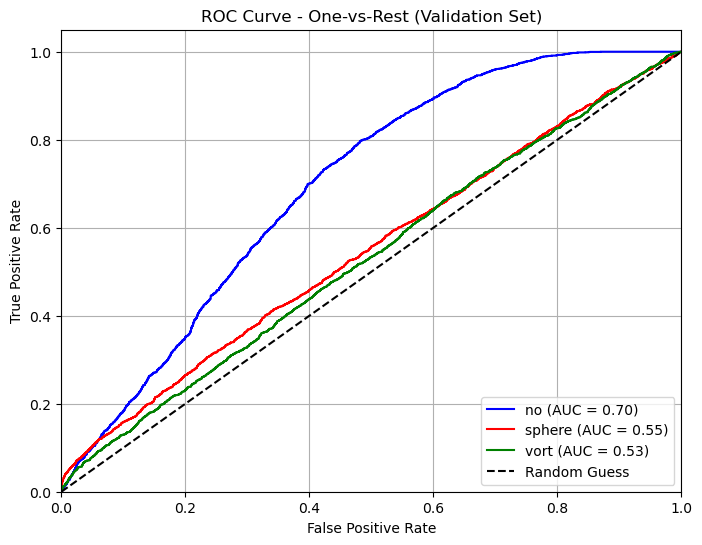

In [39]:
# Optional class names for better labeling
class_names = ["no", "sphere", "vort"]
colors = ["blue", "red", "green"]

plt.figure(figsize=(8, 6))
for c in range(num_classes):
    plt.plot(fpr[c], tpr[c], color=colors[c],
             label=f"{class_names[c]} (AUC = {roc_auc[c]:.2f})")

plt.plot([0, 1], [0, 1], "k--", label="Random Guess")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - One-vs-Rest (Validation Set)")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()
